In [1]:
# Import libraries
from Bio.PDB import PDBParser # for parsing input structure
from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lmfit import Parameters,minimize,report_fit # fot fitting helix
import io # for printing output to file
from contextlib import redirect_stdout # for printing output to file
import sys
import os
import glob

In [12]:
def makePDB(coordinates, name):
    resid=1
    atomnumb=2
    with open('%s.pdb'%name, 'w') as f:
        for i in coordinates:
            f.write('ATOM{:>7s}  CA  ALA A{:>4s}     {:>7.3f} {:>7.3f} {:>7.3f}  1.00  0.00           C\n'.format(str(atomnumb),str(resid),float(i[0]),float(i[1]),float(i[2])))
            resid=resid+1
            atomnumb=atomnumb+10
        f.write('END')
    return


#### FUNCTIONS FOR PARAMETRIC FITTING ####

# Parametric helix equation (from Huang et al. (2014), described in SI)
# Contains small patch to make it resemble the BundleGridSampler mover (define helix 'origin' at the center)

#----------MAKE CARTESIAN COORDINATES FOR CA OF RESIDUE t---------------
def cartesian(r0, omega0, omega1, phi0, phi1, delta_z, t):
    
    # SHOULD NOT BE VARIED IF WANT TO RETAIN IDEAL ALPHA-HELIX
    d=1.51 # FIXED, distance between successive residues along the helical axis, [angstrom] -- BundleGridSampler=z1
    r1=2.26 # FIXED, helical radius, [angstrom] -- BundleGridSampler=r1_peratom

    # ONLY FUNCTIONS OF OTHER PARAMETERS
    alpha=asin((r0*omega0)/d) # CONSTRAINED (function of other variables), pitch angle, [radians] -- BundleGridSampler=delta_omega1_peratom?
    # N.B. alpha is usually the issue if the script crashes due to a math domain error
    phi_prime0=phi0+delta_z*tan(alpha)/r0 # CONSTRAINED (function of other variables), superhelical phase decoupled from delta_z, [radians] 
    
    x=r0*cos(omega0*t+phi_prime0)+r1*cos(omega0*t+phi_prime0)*cos(omega1*t+phi1)-r1*cos(alpha)*sin(omega0*t+phi_prime0)*sin(omega1*t+phi1)
    y=r0*sin(omega0*t+phi_prime0)+r1*sin(omega0*t+phi_prime0)*cos(omega1*t+phi1)+r1*cos(alpha)*cos(omega0*t+phi_prime0)*sin(omega1*t+phi1)
    z=((omega0*r0)/(tan(alpha)))*t-r1*sin(alpha)*sin(omega1*t+phi1)+delta_z

    return [x,y,z]

#----------MAKE CARTESIAN COORDINATES FOR HELIX 'TRACE'---------------
def xyz_trace(r0, omega0, phi0, delta_z, t):
    
    d=1.51 # FIXED, distance between successive residues along the helical axis, [angstrom] -- BundleGridSampler=z1
    r1=2.26 # FIXED, helical radius, [angstrom] -- BundleGridSampler=r1_peratom

    # ONLY FUNCTIONS OF OTHER PARAMETERS

    alpha=asin((r0*omega0)/d) # CONSTRAINED (function of other variables), pitch angle, [radians] -- BundleGridSampler=delta_omega1_peratom?
    # N.B. alpha is usually the issue if the script crashes due to a math domain error
    phi_prime0=phi0+delta_z*tan(alpha)/r0 # CONSTRAINED (function of other variables), superhelical phase decoupled from delta_z, [radians] 
    
    # Only first part of equation, corresponds to the middle 'trace' of each helix, without helical rotation
    x=r0*cos(omega0*t+phi_prime0)
    y=r0*sin(omega0*t+phi_prime0)
    z=((omega0*r0)/(tan(alpha)))*t

    return [x,y,z]


#---------MAKE ARRAY OF XYZ COORDINATES FOR ALL CA-----------------------
def moving(r0, omega0, omega1, phi0, phi1, delta_z, helix_length,invert):

    # PATCH TO BRIDGE DIFFERENCES IN HOW THE 'ORIGIN' IS DEFINED
    delta_t=int(helix_length/2)# define an offset of half-helix length (in number of residues) -- BundleGridSampler=delta_t
    # 're-number' indices +/- around middle of helix
    # to patch Vikram's convention (start from middle of helix) and Huang's convention (start at resid 1) 
    
    # Correct for helices that have odd numbers of residues (otherwise fitting helix will be one residue short)
    if (helix_length % 2) == 0:
        residue_renumber_indices=np.arange(-delta_t,+delta_t,1)
    if (helix_length % 2) != 0:
        residue_renumber_indices=np.arange(-delta_t,+delta_t+1,1)
        
    
    if invert==True: # change direction of helix
        residue_renumber_indices=-1*residue_renumber_indices
    
    moving_coordinates=[]
    for t in residue_renumber_indices:
        
        xyz=cartesian(r0, omega0, omega1, phi0, phi1, delta_z, t)
        moving_coordinates.append(xyz)
        
    return np.array(moving_coordinates)



############ FUNCTIONS FOR GEOMETRICAL TRANSFORMATIONS ###############

# Define translation matrix
def translation(translation_axis): # general along any arbitrary vector
    return np.array([[1,0,0,translation_axis[0]],[0,1,0,translation_axis[1]],[0,0,1,translation_axis[2]],[0,0,0,1]])

# Define translation matrix with distance scaling
def translation_d(translation_axis, d): # general along any arbitrary vector AND scaled by distance d
    return np.array([[1,0,0,translation_axis[0]*d],[0,1,0,translation_axis[1]*d],[0,0,1,translation_axis[2]],[0,0,0,1]])

# Define general rotation matrix (for given angle (in radians)) around arbitrary axis
def rotation(theta,axis):
    # ux^2+uy^2+uz^2 = 1 is required !!!
    ux=axis[0]
    uy=axis[1]
    uz=axis[2]
    return np.array([[cos(theta)+(ux**2)*(1-cos(theta)), ux*uy*(1-cos(theta))-uz*sin(theta),ux*uz*(1-cos(theta))+uy*sin(theta)],
                    [uy*ux*(1-cos(theta))+uz*sin(theta), cos(theta)+(uy**2)*(1-cos(theta)),uy*uz*(1-cos(theta))-ux*sin(theta)],
                    [uz*ux*(1-cos(theta))-uy*sin(theta), uz*uy*(1-cos(theta))+ux*sin(theta), cos(theta)+(uz**2)*(1-cos(theta))]])


################ FUNCTIONS FOR GENERATION HELIX BACKBONE FROM CA TRACE ################
# From PEILONG with modifications
# convert CA trace to full backbone model by superimposing on ideal template (ideal.pdb) by matching 3 consecutive CA atoms

# Define 'stub' (from 3 atoms) - necessary for computing the transformation matrix that matches the structures 
def stub(b,a,c): # a,b,c are the vectors of a, b, c with respect to the general coordinate frame
    e1=(a-b)/np.linalg.norm(a-b)
    e3=np.cross(e1,(c-b))/np.linalg.norm(np.cross(e1,(c-b)))
    e2=np.cross(e1,e3)/np.linalg.norm(np.cross(e1,e3))
    partial_matrix = np.array([e1,e2,e3,b]).T
    extra_line=np.array([[0,0,0,1]])
    stub_matrix=np.append(partial_matrix,extra_line,axis=0)

    return stub_matrix



# Read original PDB in order to append the new helix to it
#zcon=open('mALb8_cutT2.pdb','r').readlines() 

# Function that takes CA coordinates as input and return ideal helix backbone appended to fitted PDB in one PDB file
def make_BB_from_CA(CA_coordinates,suffix,file_name,buttress):
    
    # Generate 'ideal' stub 
    stub_file=map(str.split,open('/home/bwicky/Design/add_buttressing_helix_to_zcon/ideal.pdb','r').readlines())

    atom=[]
    for line in stub_file:
        atom.append(np.array([float(line[6]),float(line[7]),float(line[8])]))

    ideal_stub=stub(atom[6],atom[1],atom[11]) # generate ideal stub from CA coordinates

    with open('buttress_%s/input_structures/%s_%s_%s.pdb'%(buttress,buttress,file_name[:-4],suffix),'w') as full_pdb:
    
        # Write original structure to file
        for line in zcon:
            if line !='END\n':
                full_pdb.write(line)
        
        # Generate and write bb of generated helix based on its CA trace
        atom_num=1
        res_num=0 
        chain='C'
        CA_chain=CA_coordinates[:,0:3]
        for res in range(1,len(CA_chain)-1):

            res_num=res_num+1
            actual_stub=stub(CA_chain[res],CA_chain[res-1],CA_chain[res+1]) # stub based on CA trace
            transform=np.matmul(actual_stub,np.linalg.inv(ideal_stub)) # find transformation matrix between ideal and actual stub

            # N
            coords=np.matmul(transform,np.append(atom[5],1))
            full_pdb.write('ATOM %6d  N   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           N\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2]))
            atom_num=atom_num+1

            # CA (use actual CA from trace rather than superimposed one)
            coords=CA_chain[res]
            # If want to use CA from ideal stub instead of actual CA
            # coords=np.matmul(transform,np.append(atom[6],1)) 
            full_pdb.write('ATOM %6d  CA  ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           C\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2]))
            atom_num=atom_num+1

            # (N)H
            coords=np.matmul(transform,np.append(atom[7],1))
            full_pdb.write('ATOM %6d  H   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           H\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2]))
            atom_num=atom_num+1

            # C(O)
            coords=np.dot(transform,np.append(atom[8],1))
            full_pdb.write('ATOM %6d  C   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           C\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2]))
            atom_num=atom_num+1

            # O
            coords=np.dot(transform,np.append(atom[9],1))
            full_pdb.write('ATOM %6d  O   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           O\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2]))
            atom_num=atom_num+1

        full_pdb.write('END')
        
    return
              

def assemble_helices(helices,name):

    # Generate 'ideal' stub 
    stub_file=map(str.split,open('/home/bwicky/Design/add_buttressing_helix_to_zcon/ideal.pdb','r').readlines())

    atom=[]
    for line in stub_file:
        atom.append(np.array([float(line[6]),float(line[7]),float(line[8])]))

    ideal_stub=stub(atom[6],atom[1],atom[11]) # generate ideal stub from CA coordinates
    
    
    chains = ['A','B','C','D','E','F','G','H','I','J']
    chain_index = 0
    with open('%s.pdb'%name, 'w') as full_pdb:

        
        # Generate and write bb of generated helix based on its CA trace
        for helix in helices:
            atom_num=1
            res_num=0 
            chain=chains[chain_index]
            CA_chain=helix[:,0:3]
            for res in range(1,len(CA_chain)-1):

                res_num=res_num+1
                actual_stub=stub(CA_chain[res],CA_chain[res-1],CA_chain[res+1]) # stub based on CA trace
                transform=np.matmul(actual_stub,np.linalg.inv(ideal_stub)) # find transformation matrix between ideal and actual stub

                # N
                coords=np.matmul(transform,np.append(atom[5],1))
                full_pdb.write('ATOM %6d  N   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           N\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2]))
                atom_num=atom_num+1

                # CA (use actual CA from trace rather than superimposed one)
                coords=CA_chain[res]
                # If want to use CA from ideal stub instead of actual CA
                # coords=np.matmul(transform,np.append(atom[6],1)) 
                full_pdb.write('ATOM %6d  CA  ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           C\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2]))
                atom_num=atom_num+1

                # (N)H
                coords=np.matmul(transform,np.append(atom[7],1))
                full_pdb.write('ATOM %6d  H   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           H\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2]))
                atom_num=atom_num+1

                # C(O)
                coords=np.dot(transform,np.append(atom[8],1))
                full_pdb.write('ATOM %6d  C   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           C\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2]))
                atom_num=atom_num+1

                # O
                coords=np.dot(transform,np.append(atom[9],1))
                full_pdb.write('ATOM %6d  O   ALA %s %3d    %8.3f%8.3f%8.3f  1.00  0.00           O\n'%(atom_num,chain,res_num,coords[0],coords[1],coords[2]))
                atom_num=atom_num+1
            chain_index+=1
        full_pdb.write('END')
        
    return
  

def sample_design(angle_range, num_helices, r0, omega0, omega1, helix_length, file_name):
    h0 = moving(.000001, radians(omega0), radians(omega1), radians(0), 0, 0, helix_length,False)
    helices = [h0]
    angle_start = (180 - angle_range)/2 + 90
    angle_increment = angle_range / (num_helices-1)
    for i in range(num_helices):
        helices.append(moving(r0, radians(omega0), radians(omega1), radians(angle_start + i*angle_increment), 0, 0, helix_length,False))
    assemble_helices(helices, file_name)
    return

In [13]:
def generator(r0_A,r0_B,r0_C,phi0_A,phi0_B,phi0_C,omega0_A,omega0_B,omega1_A,omega1_B,delta_z_A,delta_z_B,helix_lenght_A,helix_length_B, bundle_dist, ID):

    
    # Find xy coordinates based on fitted parameteres
    xy_A=np.array([cos(phi0_A)*r0_A,sin(phi0_A)*r0_A])
    xy_B=np.array([cos(phi0_B)*r0_B,sin(phi0_B)*r0_B])
    xy_C=np.array([cos(phi0_C)*r0_C,sin(phi0_C)*r0_C])


    # Compute averages for the parameters that will not sampled on the grid
    omega0_avg=(omega0_A+omega0_B)/2
    omega1_avg=(omega1_A+omega1_B)/2
    delta_z_avg=(delta_z_A+delta_z_B)/2
    helix_length_avg=(helix_lenght_A+helix_length_B)/2

    # Find the point that is equidistant from A and B on the line that connects the two
    xy_midpoint=((xy_B-xy_A)/2)+xy_A
    r_midpoint=np.sqrt(np.sum(np.power(xy_midpoint,2)))
    if xy_midpoint[0]>0 and xy_midpoint[1]>0: # quadrant I
        angle_midpoint=atan(xy_midpoint[1]/xy_midpoint[0])
    if xy_midpoint[0]<0 and xy_midpoint[1]>0: # quadrant II
        angle_midpoint=atan(xy_midpoint[1]/xy_midpoint[0])+radians(180)
    if xy_midpoint[0]<0 and xy_midpoint[1]<0: # quadrant III
        angle_midpoint=atan(xy_midpoint[1]/xy_midpoint[0])+radians(180)
    if xy_midpoint[0]>0 and xy_midpoint[1]<0: # quadrant IV
        angle_midpoint=atan(xy_midpoint[1]/xy_midpoint[0])+radians(360)



    #----------- DOT TEST ------------
    # Necessary to ensure that the translation of the newly generated helix is outwards with respect to the bundle
    AvB=np.append(xy_B-xy_A,0) # vector AB
    AvC=np.append(xy_C-xy_A,0) # vector AC (helix C or D could be used, ensures that projection is away from it)
    dot_test=False
    if np.cross(AvB,AvC)[2] < 0:
        dot_test=True
    
    #-------- ARRAYS OF PERPENDICULAR VECTORS AT THE MIDPOINT BETWEEN A AND B ----------
    trace_chA=[]
    trace_chB=[]
    trace_midpoint=[]
    perp_vectors=[]
    interation=np.arange(-helix_length_avg/2,helix_length_avg/2,1)
    for k in interation:
        # Compute helical 'trace'
        trace_A=np.array(xyz_trace(r0_A,omega0_A,phi0_A,delta_z_avg,k))+np.array([0,0,delta_z_avg])
        trace_B=np.array(xyz_trace(r0_B,omega0_B,phi0_B,delta_z_avg,k))+np.array([0,0,delta_z_avg])

        # Find points that are equidistant from A and B on the line connecting the two
        trace_mid=((trace_B-trace_A)/2)+trace_A

        trace_chA.append(trace_A)
        trace_chB.append(trace_B)
        trace_midpoint.append(trace_mid)

        # Find perpendicular vector to the line (with origin at the midpoint) that projects AWAY from the bundle
        if dot_test == False:
            perp=np.cross(trace_B-trace_mid,np.array([0,0,1]))+trace_mid
        if dot_test == True:
            perp=np.cross(trace_B-trace_mid,np.array([0,0,-1]))+trace_mid

        norm_perp_vectors=(perp-trace_mid)/np.linalg.norm(perp-trace_mid)
        perp_vectors.append(norm_perp_vectors)

        
# SAMPLING VALS #############################################################################
    dz = (np.random.random_sample()*1.5) -0.75 # originally delta_z_avg, changed to add random/diversity
    d = np.random.normal(bundle_dist,.25) # sample buttress distance with random noise
    tilting_offset= radians(np.random.random_sample()*-10) # random sample tilt between 0 and -10 degrees
    phi1=radians(np.random.random_sample()*360) # random sample phi1
#############################################################################################
    

    pdb_names=[] # for generating task array
    loop1=[] # variable to pass to the XML based on the connectivity that is possible for building the first loop
    loop2=[] # variable to pass to the XML based on the connectivity that is possible for building the second loop

    # Generate helix using averaged parameters
    # +2 for helix length necessary for reconstituation of full backbone from CA later on (otherwise will be shorter)
    # moving(r0, omega0, omega1, phi0, phi1, delta_z, helix_length,invert)    
    generated=moving(r_midpoint,omega0_avg,omega1_avg,angle_midpoint,phi1,dz,helix_length_avg+2,True)

    # Translate middle of helix into xy plane before rotation to avoid lever-arm effects
    closest_to_origin=np.argmin(np.absolute(np.array(trace_midpoint)),axis=0)[2]
    shift_v=trace_midpoint[closest_to_origin]-trace_midpoint[int(len(interation)/2)]
    shift_matrix=translation(shift_v)
    shifted_list=[]
    for line in generated:
        add=np.append(line,1)
        coord=np.dot(shift_matrix,add)
        shifted_list.append(coord)
    shifted=np.array(shifted_list)

    # Rotate around projection vector
    tilt_v=trace_midpoint[-1]-trace_midpoint[0]
    tilt_angle=acos(np.dot(tilt_v,np.array([0,0,1]))/(np.linalg.norm(tilt_v)))
#     tilt_angle=0
    rotation_matrix=rotation(-tilt_angle+tilting_offset,perp_vectors[int(len(interation)/2)])
    rotated=np.dot(shifted[:,0:3],rotation_matrix)

    # Shift back into position
    shift_back_matrix=translation(-shift_v)
    shifted_back_list=[]
    for line in rotated:
        add=np.append(line,1)
        coord=np.dot(shift_back_matrix,add)
        shifted_back_list.append(coord)
    shifted_back=np.array(shifted_back_list)

    # Translate outwards along projection vector
    translate_out_matrix=translation_d(perp_vectors[int(len(interation)/2)],d)
    trans_out_list=[]
    for line in shifted_back:
        coord=np.dot(translate_out_matrix,line)
        trans_out_list.append(coord)
    trans_out=np.array(trans_out_list)

#     makePDB(generated,'generated%s'%ID)
#     makePDB(shifted,'shifted%s'%ID)
#     makePDB(rotated,'rotated%s'%ID)
#     makePDB(shifted_back,'shifted_back_%s'%ID)
#     makePDB(trans_out,'trans_out_%s'%ID)        
    return trans_out

In [14]:
def random_sample_design(num_helices, helix_length, file_name):
    
    omega0 = 0
    while omega0 > -1: # set cutoff for omega0 -- require some supercoiling
        # SAMPLE OMEGA0 ON GAMMA DISTRIBUTION WITH XFACT MAX
        x = np.random.gamma(1.1, .4)
        xfact = 1.75
        while x > xfact:
            x = np.random.gamma(1, .4)
        omega0 = (2.85*(x/xfact)-2.85)

    omega1 = 100 - omega0
    #omega0 = np.random.triangular(-2.85,-2.85, 0) # favor more supercoil since looping favors straight bundles
    #omega0 = np.random.random_sample()*-2.85
    
    # RANDOM SAMPLE PHI1
    phi1 = np.random.random_sample()*360
    
    # PLACE GROOVE HELIX
    #h0 = moving(.0000000000001, radians(omega0), radians(omega1), radians(0), radians(phi1), 0, helix_length +14,True)
    helices = []#h0]
    tot_angle = 0
    phi0s = [tot_angle]
    r0s = [.0000000000001]

    # BUNDLE DIST IS EQUIVALENT TO BUTTRESS DISTANCE, i.e. DIST BUTTRESS IS FROM MIDPOINT OF TWO HELICES
    # BUNDLE DIST * HYP_F IS SIDE LENGTH, i.e. DIST BETWEEN EVERY HELIX
    bundle_dist = np.random.normal(8.75,.4) # normal dist around 9 with 2sigma = 1.5
    hyp_f = 2 / sqrt(3)
    
    # define a bundle distance/tightness for whole bundle, then sample noise
    # this reduces distance variation between helices within the same bundle
    for i in range(num_helices):
        phi1 = np.random.random_sample()*360 # continuous uniform dist for phi1
        r0 = np.random.normal(bundle_dist*hyp_f, 0.18*hyp_f) # sample distances around bundle_dist with noise
        r0s.append(r0)
        r0_2 = np.random.normal(bundle_dist*hyp_f, 0.18*hyp_f)
        angle_increment = 2*np.arcsin(r0_2 / (2*r0)) # distance to adjacent helix, also same normal dist
        tot_angle += angle_increment
        phi0s.append(tot_angle)
        dz = (np.random.random_sample()*1.5) -0.75 # sample full range of deltaz, since rise of ahelix is 1.5
        helices.append(moving(r0, radians(omega0), radians(omega1), tot_angle, radians(phi1), dz, helix_length,False))
            
    buttresses = []
    for j in range(num_helices - 1):
        A_ind = 1 + j
        B_ind = 2 + j
        buttresses.append(generator(r0s[A_ind],r0s[B_ind],r0s[0],phi0s[A_ind],phi0s[B_ind],phi0s[0],radians(omega0),radians(omega0),radians(omega1),radians(omega1),0.00000001,0.00000001,helix_length,helix_length,bundle_dist,file_name))
    helices += buttresses # add buttresses to end

    design_name = file_name+'_'+str(round(-omega0,3))+'_'+str(round(bundle_dist,3))
    assemble_helices(helices, design_name)
    
    return design_name

<AxesSubplot:>

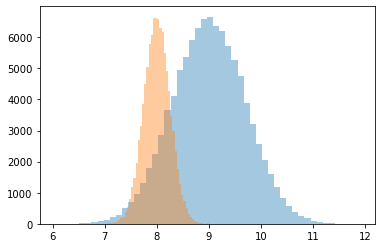

In [5]:
# OLD SAMPLING DISTRIBUTIONS
sns.distplot(np.random.normal(9,.7,100000), kde=False)
sns.distplot(np.random.normal(8,.25,100000), kde=False)

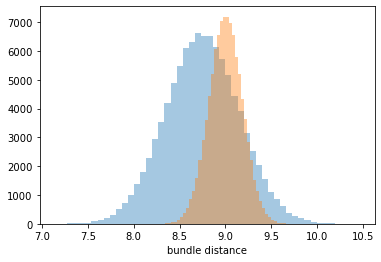

In [3]:
# NEW SAMPLING DISTRIBUTIONS
sns.distplot(np.random.normal(8.75,.4,100000), kde=False)
sns.distplot(np.random.normal(9,.18,100000), kde=False)
plt.xlabel("bundle distance")
plt.savefig('figs/bundle_distance_distributions.pdf')

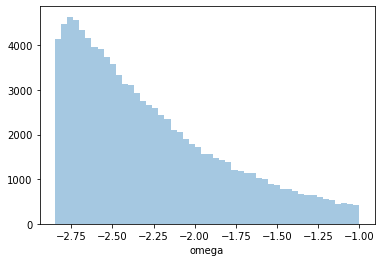

In [4]:
os = []
for i in range(100000):
    omega0 = 0
    while omega0 > -1: # set cutoff for omega0 -- require some supercoiling
        # SAMPLE OMEGA0 ON GAMMA DISTRIBUTION WITH XFACT MAX
        x = np.random.gamma(1.1, .4)
        xfact = 1.75
        while x > xfact:
            x = np.random.gamma(1, .4)
        omega0 = (2.85*(x/xfact)-2.85)
    os.append(omega0)
sns.distplot(os,kde=False)
plt.xlabel("omega")
plt.savefig('figs/supercoiling_distribution.pdf')

In [15]:
pdb_names = []

In [19]:
for i in range(0): # range(200000)
    if i %500 == 0:
        print(i)
    name = "loops_batch2/input_structures/3h_15"
    pdb_names.append('input_structures/%s.pdb'%(random_sample_design(3, 15, name)).split('/')[-1])
    name = "loops_batch2/input_structures/3h_16"
    pdb_names.append('input_structures/%s.pdb'%(random_sample_design(3, 16, name)).split('/')[-1])
    name = "loops_batch2/input_structures/3h_17"
    pdb_names.append('input_structures/%s.pdb'%(random_sample_design(3, 17, name)).split('/')[-1])
    name = "loops_batch2/input_structures/3h_18"
    pdb_names.append('input_structures/%s.pdb'%(random_sample_design(3, 18, name)).split('/')[-1])
    name = "loops_batch2/input_structures/3h_19"
    pdb_names.append('input_structures/%s.pdb'%(random_sample_design(3, 19, name)).split('/')[-1])

0


In [ ]:
rosetta_path = "/software/rosetta/versions/v2019.21-dev60746/bin/rosetta_scripts.hdf5.linuxgccrelease" # static version
commandList=[]
for i in range(len(pdb_names)):
    command='%s @flags -in:file:s %s'%(rosetta_path,pdb_names[i])
    commandList.append(command)
with open("loops/tasks","w") as f:
    for task in commandList:
        f.write(task + "\n")

In [5]:
path3 = 'loops_batch2'
in_files = glob.glob('{}/input_structures/*.pdb'.format(path3))
out_files = glob.glob('{}/output_structures/*.pdb'.format(path3))

in_omegas = []
in_bs = []
in_lens = []
for i in in_files:
    in_omegas.append(-float(i.split("_")[4]))
    in_bs.append(float(i.split("_")[5][:-4]))
    in_lens.append(float(i.split("_")[3]))
out_omegas = []
out_bs = []
out_lens = []
for i in out_files:
    out_omegas.append(-float(i.split("_")[4]))
    out_bs.append(float(i.split("_")[5]))
    out_lens.append(float(i.split("_")[3]))

print(len(out_omegas)/len(in_omegas))

0.6672866542669147


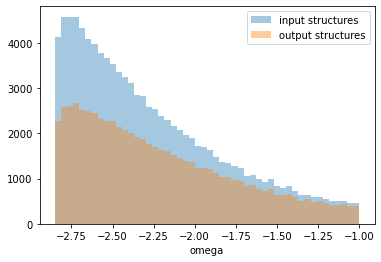

In [7]:
sns.distplot(in_omegas, kde=False, label="input structures")
sns.distplot(out_omegas, kde=False,label="output structures")
plt.xlabel("omega")
plt.legend()
plt.savefig('supercoiling_in_out.pdf')

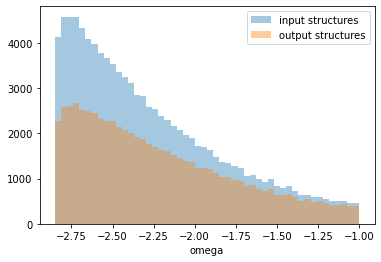

In [4]:
sns.distplot(in_omegas, kde=False, label="input structures")
sns.distplot(out_omegas, kde=False,label="output structures")
plt.xlabel("omega")
plt.legend()

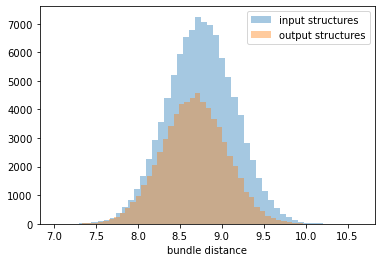

In [8]:
sns.distplot(in_bs, kde=False, label="input structures")
sns.distplot(out_bs, kde=False,label="output structures")
plt.xlabel("bundle distance")
plt.legend()
plt.savefig('bundle_distance_in_out.pdf')

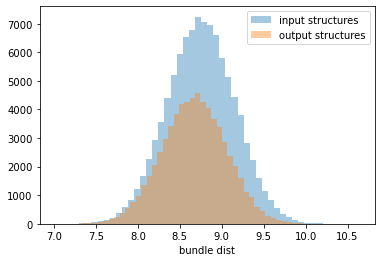

In [5]:
sns.distplot(in_bs, kde=False, label="input structures")
sns.distplot(out_bs, kde=False,label="output structures")
plt.xlabel("bundle distance")
plt.legend()

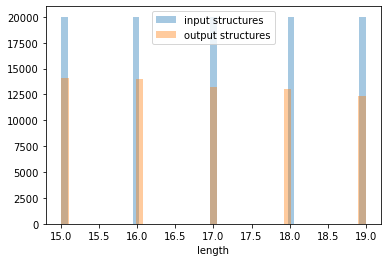

In [9]:
sns.distplot(in_lens, kde=False, label="input structures")
sns.distplot(out_lens, kde=False,label="output structures")
plt.xlabel("length")
plt.legend()
plt.savefig('length_in_out.pdf')